## I.Introduction

:label:`sec_bptt`

If you completed the exercises in :numref:`sec_rnn-scratch`,
you would have seen that gradient clipping is vital 
for preventing the occasional massive gradients
from destabilizing training.
We hinted that the exploding gradients
stem from backpropagating across long sequences.
Before introducing a slew of modern RNN architectures,
let's take a closer look at how *backpropagation*
works in sequence models in mathematical detail.
Hopefully, this discussion will bring some precision 
to the notion of *vanishing* and *exploding* gradients.
If you recall our discussion of forward and backward 
propagation through computational graphs
when we introduced MLPs in :numref:`sec_backprop`,
then forward propagation in RNNs
should be relatively straightforward.
Applying backpropagation in RNNs 
is called *backpropagation through time* :cite:`Werbos.1990`.
This procedure requires us to expand (or unroll) 
the computational graph of an RNN
one time step at a time.
The unrolled RNN is essentially 
a feedforward neural network 
with the special property 
that the same parameters 
are repeated throughout the unrolled network,
appearing at each time step.
Then, just as in any feedforward neural network,
we can apply the chain rule, 
backpropagating gradients through the unrolled net.
The gradient with respect to each parameter
must be summed across all places 
that the parameter occurs in the unrolled net.
Handling such weight tying should be familiar 
from our chapters on convolutional neural networks.


Complications arise because sequences
can be rather long.
It is not unusual to work with text sequences
consisting of over a thousand tokens. 
Note that this poses problems both from 
a computational (too much memory)
and optimization (numerical instability)
standpoint. 
Input from the first step passes through
over 1000 matrix products before arriving at the output, 
and another 1000 matrix products 
are required to compute the gradient. 
We now analyze what can go wrong and 
how to address it in practice.

##  My Note for Introduction

*   **Importance of Gradient Clipping**: The content above highlight that **gradient clipping is vital** for preventing **occasional massive gradients** from destabilizing the training process of RNNs. You would have encountered this necessity in the exercises from Section 9.5. Gradient clipping is an **inelegant but ubiquitous solution** used to limit the size of exploding gradients by forcing them to take smaller values, thereby preventing large updates that can destabilize training and cause the neural network to diverge.

*   **Origin of Exploding Gradients**: The text points out that **exploding gradients stem from backpropagating across long sequences**. In RNNs, the "depth" of the network isn't just about the number of layers in a single time step, but also the length of the sequence. An input at the first time step influences the output at the final time step by passing through a chain of `T` (sequence length) layers along the time steps. When computing gradients backwards, this results in a chain of matrix-products of length `O(T)`. Such long chains can lead to numerical instability, causing gradients to either explode or vanish, depending on the properties of the weight matrices.

*   **Backpropagation Through Time (BPTT) Definition**:
    *   **BPTT** is the name given to the process of **applying backpropagation in sequence models**. This method was introduced by Werbos in 1990.
    *   To perform BPTT, the **computational graph of an RNN is expanded or "unrolled" one time step at a time**. This effectively transforms the recurrent network into what looks like a very **deep feedforward neural network**.
    *   A unique characteristic of this unrolled network is that the **same parameters are repeated throughout**, appearing at each time step. This is known as **weight tying**.
    *   Once unrolled, the standard **chain rule** is applied to backpropagate gradients through this expanded network, just as in any feedforward neural network.
    *   A crucial step in BPTT is that the **gradient with respect to each parameter must be summed across all places that the parameter occurs in the unrolled net**. This summation accounts for the shared nature of the weights across time steps. This concept of shared parameters and summing gradients should be familiar from convolutional neural networks.

*   **Precision to Vanishing and Exploding Gradients**: The detailed analysis of how backpropagation works mathematically in sequence models provides a precise understanding of the **vanishing and exploding gradient problems**. These problems arise because the gradient calculation for hidden layer weights involves a **recursive dependency** that, when expanded, includes a sum of terms involving products of derivatives from many past time steps. Specifically, in simplified linear models, this involves potentially very large powers of weight matrices ($\mathbf{W}_\textrm{hh}^\top$). If the eigenvalues of these matrices are smaller than 1, gradients vanish; if larger than 1, they diverge, leading to numerical instability.


When dealing with **long sequences** in Recurrent Neural Networks (RNNs), such as text sequences consisting of over a thousand tokens, two main categories of problems arise: **computational issues** (too much memory) and **optimization issues** (numerical instability).
### Computational Problems (Too Much Memory)

*   **Unrolling the Computational Graph**: In RNNs, applying backpropagation requires "unrolling" the computational graph of the network one time step at a time. This unrolled RNN can be thought of as a very deep feedforward neural network, where the same parameters are shared across all time steps (layers).
*   **Memory Consumption**: For a sequence with over a thousand tokens, this unrolling creates a computational graph with thousands of effective "layers" or time steps. During backpropagation, **all intermediate activations and gradients at each time step must be stored in memory** to compute the final gradients. This can quickly lead to an **excessive memory requirement**, making training infeasible for very long sequences.

### Optimization Problems (Numerical Instability: Exploding and Vanishing Gradients)

*   **Backpropagation Through Time and Chain Rule**: When computing gradients in RNNs, especially with respect to the hidden layer weights ($w_h$ or $\mathbf{W}_{\text{hh}}$), the chain rule is applied across many time steps. The total derivative of the hidden state at time $t$ with respect to $w_h$ involves a sum of terms, each containing a **product of derivatives (Jacobians) across previous time steps**. For long sequences, this translates to a chain of **hundreds or thousands of matrix products** during the gradient computation.
*   **Exploding Gradients**:
    *   This occurs when the norm of the gradients ($\|\mathbf{g}\|$) becomes **"excessively large"**.
    *   Mathematically, this happens when the eigenvalues of the weight matrices (specifically $\mathbf{W}_{\text{hh}}^\top$ in the simplified model) are **larger than 1** when raised to high powers.
    *   When gradients explode, a single gradient step can be so drastic that it **"could undo all of the progress made over the course of thousands of training iterations"**.
    *   This often leads to neural network training **diverging**, meaning it fails to reduce the objective function's value, or it converges in an **unstable manner with "massive spikes in the loss"**.
*   **Vanishing Gradients**:
    *   Although the query focuses on exploding gradients, the sources also highlight vanishing gradients as a fundamental problem arising from numerical instability in RNNs.
    *   This occurs when the eigenvalues of the weight matrices are **smaller than 1** when raised to high powers, causing the gradients to become extremely small. When gradients vanish, the updates to parameters become negligible, effectively stopping the learning process, especially for long-term dependencies.

### How to Address These Problems in Practice

*   **Gradient Clipping (for Exploding Gradients)**:
    *   This is an "inelegant but ubiquitous solution" to exploding gradients.
    *   The core idea is to **limit the maximum norm of the gradient vector**. If the calculated gradient's norm exceeds a predefined threshold ($\theta$), the gradient is scaled down proportionally so its norm equals $\theta$. The formula for this is $\mathbf{g} \leftarrow \min \left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}$.
    *   This ensures that the gradient norm never exceeds $\theta$ and maintains the direction of the original gradient, preventing drastically large updates that could destabilize training. It's considered a "hack" because it doesn't follow the true gradient, but it's very effective and widely adopted. The training process typically calculates gradients, then clips them, and finally updates model parameters using these clipped gradients.
*   **Truncated Backpropagation Through Time (for both Memory and Instability)**:
    *   This is the most common practical approach for handling long sequences.
    *   Instead of backpropagating through the entire sequence, the sum of gradients in the chain rule is **truncated after a fixed number of steps** (e.g., `num_steps` or $\tau$).
    *   This means the model only considers a limited window of past observations for calculating gradients, thus **reducing the computational graph length** and **mitigating numerical instability** by limiting the number of matrix products in the chain.
    *   While it's an "approximation" of the true gradient, it works well in practice and biases the model towards simpler and more stable learning by focusing on short-term influences.
    *   This method is often referred to as "regular truncation" and is more commonly used than "randomized truncation" due to its practical advantages, despite the latter being theoretically more accurate in expectation.
*   **More Sophisticated Architectures**:
    *   Beyond these general techniques, more advanced RNN architectures, such as **Long Short-Term Memory (LSTM)** networks, were specifically designed to alleviate the vanishing gradient problem and improve the handling of long-term dependencies. These will be discussed in later sections of the sources.

## II.Analysis of Gradients in RNNs
:label:`subsec_bptt_analysis`

We start with a simplified model of how an RNN works.
This model ignores details about the specifics 
of the hidden state and how it is updated.
The mathematical notation here
does not explicitly distinguish
scalars, vectors, and matrices.
We are just trying to develop some intuition.
In this simplified model,
we denote $h_t$ as the hidden state,
$x_t$ as input, and $o_t$ as output
at time step $t$.
Recall our discussions in
:numref:`subsec_rnn_w_hidden_states`
that the input and the hidden state
can be concatenated before being multiplied 
by one weight variable in the hidden layer.
Thus, we use $w_\textrm{h}$ and $w_\textrm{o}$ to indicate the weights 
of the hidden layer and the output layer, respectively.
As a result, the hidden states and outputs 
at each time step are

$$\begin{aligned}h_t &= f(x_t, h_{t-1}, w_\textrm{h}),\\o_t &= g(h_t, w_\textrm{o}),\end{aligned}$$
:eqlabel:`eq_bptt_ht_ot`

where $f$ and $g$ are transformations
of the hidden layer and the output layer, respectively.
Hence, we have a chain of values 
$\{\ldots, (x_{t-1}, h_{t-1}, o_{t-1}), (x_{t}, h_{t}, o_t), \ldots\}$ 
that depend on each other via recurrent computation.
The forward propagation is fairly straightforward.
All we need is to loop through the $(x_t, h_t, o_t)$ triples one time step at a time.
The discrepancy between output $o_t$ and the desired target $y_t$ 
is then evaluated by an objective function 
across all the $T$ time steps as

$$L(x_1, \ldots, x_T, y_1, \ldots, y_T, w_\textrm{h}, w_\textrm{o}) = \frac{1}{T}\sum_{t=1}^T l(y_t, o_t).$$



For backpropagation, matters are a bit trickier, 
especially when we compute the gradients 
with regard to the parameters $w_\textrm{h}$ of the objective function $L$. 
To be specific, by the chain rule,

$$\begin{aligned}\frac{\partial L}{\partial w_\textrm{h}}  & = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial w_\textrm{h}}  \\& = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial o_t} \frac{\partial g(h_t, w_\textrm{o})}{\partial h_t}  \frac{\partial h_t}{\partial w_\textrm{h}}.\end{aligned}$$
:eqlabel:`eq_bptt_partial_L_wh`

The first and the second factors of the
product in :eqref:`eq_bptt_partial_L_wh`
are easy to compute.
The third factor $\partial h_t/\partial w_\textrm{h}$ is where things get tricky, 
since we need to recurrently compute the effect of the parameter $w_\textrm{h}$ on $h_t$.
According to the recurrent computation
in :eqref:`eq_bptt_ht_ot`,
$h_t$ depends on both $h_{t-1}$ and $w_\textrm{h}$,
where computation of $h_{t-1}$
also depends on $w_\textrm{h}$.
Thus, evaluating the total derivate of $h_t$ 
with respect to $w_\textrm{h}$ using the chain rule yields

$$\frac{\partial h_t}{\partial w_\textrm{h}}= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}} +\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_\textrm{h}}.$$
:eqlabel:`eq_bptt_partial_ht_wh_recur`


To derive the above gradient, assume that we have 
three sequences $\{a_{t}\},\{b_{t}\},\{c_{t}\}$ 
satisfying $a_{0}=0$ and $a_{t}=b_{t}+c_{t}a_{t-1}$ for $t=1, 2,\ldots$.
Then for $t\geq 1$, it is easy to show

$$a_{t}=b_{t}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t}c_{j}\right)b_{i}.$$
:eqlabel:`eq_bptt_at`

By substituting $a_t$, $b_t$, and $c_t$ according to

$$\begin{aligned}a_t &= \frac{\partial h_t}{\partial w_\textrm{h}},\\
b_t &= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}}, \\
c_t &= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}},\end{aligned}$$

the gradient computation in :eqref:`eq_bptt_partial_ht_wh_recur` satisfies
$a_{t}=b_{t}+c_{t}a_{t-1}$.
Thus, per :eqref:`eq_bptt_at`, 
we can remove the recurrent computation 
in :eqref:`eq_bptt_partial_ht_wh_recur` with

$$\frac{\partial h_t}{\partial w_\textrm{h}}=\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t} \frac{\partial f(x_{j},h_{j-1},w_\textrm{h})}{\partial h_{j-1}} \right) \frac{\partial f(x_{i},h_{i-1},w_\textrm{h})}{\partial w_\textrm{h}}.$$
:eqlabel:`eq_bptt_partial_ht_wh_gen`

While we can use the chain rule to compute $\partial h_t/\partial w_\textrm{h}$ recursively, 
this chain can get very long whenever $t$ is large.
Let's discuss a number of strategies for dealing with this problem.

### Full Computation ### 

One idea might be to compute the full sum in :eqref:`eq_bptt_partial_ht_wh_gen`.
However, this is very slow and gradients can blow up,
since subtle changes in the initial conditions
can potentially affect the outcome a lot.
That is, we could see things similar to the butterfly effect,
where minimal changes in the initial conditions 
lead to disproportionate changes in the outcome.
This is generally undesirable.
After all, we are looking for robust estimators that generalize well. 
Hence this strategy is almost never used in practice.

### Truncating Time Steps###

Alternatively,
we can truncate the sum in
:eqref:`eq_bptt_partial_ht_wh_gen`
after $\tau$ steps. 
This is what we have been discussing so far. 
This leads to an *approximation* of the true gradient,
simply by terminating the sum at $\partial h_{t-\tau}/\partial w_\textrm{h}$. 
In practice this works quite well. 
It is what is commonly referred to as truncated 
backpropgation through time :cite:`Jaeger.2002`.
One of the consequences of this is that the model 
focuses primarily on short-term influence 
rather than long-term consequences. 
This is actually *desirable*, since it biases the estimate 
towards simpler and more stable models.


### Randomized Truncation ### 

Last, we can replace $\partial h_t/\partial w_\textrm{h}$
by a random variable which is correct in expectation 
but truncates the sequence.
This is achieved by using a sequence of $\xi_t$
with predefined $0 \leq \pi_t \leq 1$,
where $P(\xi_t = 0) = 1-\pi_t$ and 
$P(\xi_t = \pi_t^{-1}) = \pi_t$, thus $E[\xi_t] = 1$.
We use this to replace the gradient
$\partial h_t/\partial w_\textrm{h}$
in :eqref:`eq_bptt_partial_ht_wh_recur`
with

$$z_t= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}} +\xi_t \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_\textrm{h}}.$$


It follows from the definition of $\xi_t$ 
that $E[z_t] = \partial h_t/\partial w_\textrm{h}$.
Whenever $\xi_t = 0$ the recurrent computation
terminates at that time step $t$.
This leads to a weighted sum of sequences of varying lengths,
where long sequences are rare but appropriately overweighted. 
This idea was proposed by 
:citet:`Tallec.Ollivier.2017`.

### Comparing Strategies

![Comparing strategies for computing gradients in RNNs. From top to bottom: randomized truncation, regular truncation, and full computation.](../img/truncated-bptt.svg)
:label:`fig_truncated_bptt`


:numref:`fig_truncated_bptt` illustrates the three strategies 
when analyzing the first few characters of *The Time Machine* 
using backpropagation through time for RNNs:

* The first row is the randomized truncation that partitions the text into segments of varying lengths.
* The second row is the regular truncation that breaks the text into subsequences of the same length. This is what we have been doing in RNN experiments.
* The third row is the full backpropagation through time that leads to a computationally infeasible expression.


Unfortunately, while appealing in theory, 
randomized truncation does not work 
much better than regular truncation, 
most likely due to a number of factors.
First, the effect of an observation
after a number of backpropagation steps 
into the past is quite sufficient 
to capture dependencies in practice. 
Second, the increased variance counteracts the fact 
that the gradient is more accurate with more steps. 
Third, we actually *want* models that have only 
a short range of interactions. 
Hence, regularly truncated backpropagation through time 
has a slight regularizing effect that can be desirable.



## My Note For 9.7.1
### Simplified RNN Model Components
In this simplified model, at each time step $t$:
*   **$h_t$** denotes the **hidden state**.
*   **$x_t$** represents the **input**.
*   **$o_t$** signifies the **output**.
*   **$w_h$** indicates the **weights of the hidden layer**.
*   **$w_o$** indicates the **weights of the output layer**.

The sources remind us that the input and hidden state can be concatenated before being multiplied by a single weight variable in the hidden layer, which $w_h$ broadly represents here.

### Formula (9.7.1): Hidden State and Output Computation
The core of the RNN's recurrent nature is captured by how its hidden state and output are computed at each time step. Formula (9.7.1) expresses these computations:

**H*t* = 𝜙(X*t*Wxh + H*t*-1Whh + bh)**
**O*t* = H*t*Whq + bq**

In the simplified notation of Section 9.7.1, these become:
*   **$h_t = f(x_t, h_{t-1}, w_h)$**
    *   This equation defines how the **hidden state at the current time step $t$ ($h_t$) is calculated**.
    *   It depends on three main components:
        *   The **current input $x_t$**: The information being fed into the network at this specific time step.
        *   The **previous hidden state $h_{t-1}$**: This is the "memory" or "state" of the network from the preceding time step. Its inclusion is what makes RNNs "recurrent" and allows them to capture dependencies over time.
        *   The **hidden layer weights $w_h$**: These are the parameters that the model learns to transform the input and previous hidden state into the new hidden state. The function $f$ represents this transformation, including any activation functions (like tanh, as used in the `RNNScratch` implementation) and the combination of input-to-hidden and hidden-to-hidden weights. As discussed previously, the hidden state update combines the current input and the previous hidden state, passing the result through an activation function.
*   **$o_t = g(h_t, w_o)$**
    *   This equation defines how the **output at the current time step $t$ ($o_t$) is calculated**.
    *   It depends on:
        *   The **current hidden state $h_t$**: The processed information up to time step $t$ is used to generate the output for this step.
        *   The **output layer weights $w_o$**: These are the parameters that transform the hidden state into the final output. The function $g$ represents this transformation, analogous to how $H_t$ is multiplied by $W_{hq}$ and summed with $b_q$ in a more detailed RNN definition.

Together, these equations illustrate a **chain of values** $\{\ldots, (x_{t-1}, h_{t-1}, o_{t-1}), (x_t, h_t, o_t), \ldots\}$ where each triplet depends on the previous one via recurrent computation. This dependency structure is key to how RNNs process sequential data, where elements are related over time.

### Formula (9.7.2): Objective Function (Loss Calculation)
After the forward propagation, where outputs $o_t$ are generated for each time step, the model's performance is evaluated using an objective function (or loss function). Formula (9.7.2) details this calculation:

*   **$L (x_1, \ldots, x_T, y_1, \ldots, y_T, w_h, w_o) = \frac{1}{T}\sum_{t=1}^T l(y_t, o_t)$**
    *   This represents the **total objective function $L$**, which is the **average loss over all $T$ time steps** of the sequence.
    *   **Purpose**: It quantifies the "discrepancy" between the model's predicted outputs ($o_t$) and the desired target values ($y_t$) across the entire sequence.
    *   **Summation $\sum_{t=1}^T$**: The total loss is computed by summing the individual losses from each time step $t=1$ to $T$.
    *   **Individual Loss $l(y_t, o_t)$**: This denotes the loss incurred at a single time step $t$, based on the predicted output $o_t$ and the true target $y_t$. Common choices for $l$ include cross-entropy loss for classification tasks.
    *   **Averaging $\frac{1}{T}$**: The sum of individual losses is divided by the total number of time steps $T$. This averaging makes the loss comparable across sequences of different lengths, similar to how perplexity normalizes likelihoods in language models.

These formulas lay the groundwork for understanding how gradients are computed and backpropagated through time in RNNs, which becomes trickier for parameters like $w_h$ due to their recurrent dependency on previous hidden states. The "long chains of dependencies" are what lead to the challenges of vanishing and exploding gradients, prompting the need for techniques like truncated BPTT.

### Formula (9.7.3): Gradient of Total Loss with Respect to Hidden Weights
To understand how the model learns, we need to compute the gradient of the total objective function $L$ with respect to the hidden layer weights $w_h$. Since $w_h$ is shared across all time steps in an RNN, its influence on the total loss must be summed up from each time step where it contributes. Using the **chain rule** and summing across all time steps, the gradient is given by:

**$\frac{\partial L}{\partial w_\textrm{h}} = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial w_\textrm{h}} = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial o_t} \frac{\partial g(h_t, w_\textrm{o})}{\partial h_t} \frac{\partial h_t}{\partial w_\textrm{h}}$**

**Why this formula?**
*   **Summation over $T$**: The total loss $L$ is a sum over all time steps, so by linearity of differentiation, the derivative of $L$ with respect to $w_h$ is the sum of derivatives of each $l(y_t, o_t)$ with respect to $w_h$. The $1/T$ factor is from the averaging in the objective function.
*   **Chain Rule**: Each $l(y_t, o_t)$ depends on $o_t$, which depends on $h_t$, which in turn depends on $w_h$. The chain rule correctly accounts for these dependencies:
    *   $\frac{\partial l(y_t, o_t)}{\partial o_t}$: How the loss changes with respect to the output at time $t$. This is typically straightforward to compute (e.g., derivative of cross-entropy).
    *   $\frac{\partial g(h_t, w_\textrm{o})}{\partial h_t}$: How the output $o_t$ changes with respect to the hidden state $h_t$. This is also generally straightforward, as $g$ is a simple transformation (e.g., a linear layer).
    *   $\frac{\partial h_t}{\partial w_\textrm{h}}$: This is the **tricky part**. It represents how the current hidden state $h_t$ is affected by the hidden layer weights $w_h$. Its complexity arises because $h_t$ depends on $h_{t-1}$, and $h_{t-1}$ itself depends on $w_h$. This forms a **recurrent dependency**.

### Formula (9.7.4): Recursive Gradient of Hidden State
To compute $\frac{\partial h_t}{\partial w_\textrm{h}}$, we again apply the chain rule, considering both the direct and indirect influences of $w_h$ on $h_t$:

**$\frac{\partial h_t}{\partial w_\textrm{h}}= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}} +\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_\textrm{h}}$**

**Why this formula?**
*   **First Term ($\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}}$)**: This accounts for the **direct impact** of $w_h$ on $h_t$ at the current time step. It's the derivative of the transformation function $f$ with respect to $w_h$, assuming $h_{t-1}$ is a constant at this point.
*   **Second Term ($\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_\textrm{h}}$)**: This accounts for the **indirect impact** of $w_h$ on $h_t$ through the **previous hidden state $h_{t-1}$**.
    *   $\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}}$: How the current hidden state $h_t$ changes with respect to the previous hidden state $h_{t-1}$. This is the "recurrent connection" part.
    *   $\frac{\partial h_{t-1}}{\partial w_\textrm{h}}$: This is the crucial **recurrent term**. It means that to calculate $\frac{\partial h_t}{\partial w_\textrm{h}}$, you need to know $\frac{\partial h_{t-1}}{\partial w_\textrm{h}}$, which in turn needs $\frac{\partial h_{t-2}}{\partial w_\textrm{h}}$, and so on, all the way back to $h_0$ (which is typically initialized and doesn't depend on $w_h$). This recursive dependency is the core of BPTT.

### Formulas (9.7.5) and (9.7.6): Unrolling the Recursion
To solve the recursive gradient calculation in (9.7.4), the sources introduce a general recurrence relation:
*   Let $a_t = b_t + c_t a_{t-1}$ with $a_0 = 0$.
*   This general form can be expanded to remove the recursion:
    **$a_{t}=b_{t}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t}c_{j}\right)b_{i}$**.

**Why this helper?**
This mathematical identity provides a way to express a value $a_t$ that depends on $a_{t-1}$ as a sum of terms that only depend on $b_k$ and $c_k$ for $k \le t$, effectively "unrolling" the recurrence.

Then, the specific terms from our RNN gradient (9.7.4) are substituted into this general form:
*   **$a_t = \frac{\partial h_t}{\partial w_\textrm{h}}$**
*   **$b_t = \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}}$**
*   **$c_t = \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}}$**

This substitution explicitly links the general recursive solution to the specific gradient problem in RNNs.

### Formula (9.7.7): Explicit Unrolled Gradient of Hidden State
By substituting $a_t, b_t, c_t$ back into the expanded form of $a_t$ from (9.7.5), we get the full, non-recursive expression for $\frac{\partial h_t}{\partial w_\textrm{h}}$:

**$\frac{\partial h_t}{\partial w_\textrm{h}}=\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t} \frac{\partial f(x_{j},h_{j-1},w_\textrm{h})}{\partial h_{j-1}} \right) \frac{\partial f(x_{i},h_{i-1},w_\textrm{h})}{\partial w_\textrm{h}}$**

**Why this formula?**
*   This formula **explicitly shows the "backpropagation through time"**. The derivative of $h_t$ with respect to $w_h$ depends on a sum of terms. Each term represents the influence of $w_h$ at a specific past time step $i$ on the current hidden state $h_t$.
*   The product term $\prod_{j=i+1}^{t} \frac{\partial f(x_{j},h_{j-1},w_\textrm{h})}{\partial h_{j-1}}$ is a chain of derivatives of $f$ with respect to its previous hidden state argument, effectively showing how the influence from time step $i$ propagates forward through all subsequent hidden states up to $t$.
*   **The problem it highlights**: This long chain of multiplications, particularly the product of terms involving $\frac{\partial f(\ldots)}{\partial h_{j-1}}$, is the root cause of **vanishing and exploding gradients**. If these individual derivatives are consistently less than 1, the product can vanish to zero, leading to vanishing gradients. If they are consistently greater than 1, the product can explode, leading to exploding gradients.

### Strategies for Addressing the Problem

Since computing the full sum in (9.7.7) is "very slow" and prone to exploding gradients (likened to the "butterfly effect" where small changes disproportionately affect the outcome), it's "almost never used in practice". Instead, the sources discuss several strategies:

*   **Truncating Time Steps (Regular Truncation)**: This is the most common practical approach where the sum in (9.7.7) is "truncated after $\tau$ steps". This means backpropagation is only performed over a fixed, limited number of past time steps. This "approximates the true gradient" but "works quite well in practice". It biases the model towards focusing on "short-term influence" which can be desirable as it leads to "simpler and more stable models". This method also helps with memory consumption by limiting the length of the unrolled graph.

*   **Randomized Truncation**: This approach replaces the exact gradient term $\frac{\partial h_t}{\partial w_h}$ with a random variable $z_t$ that is "correct in expectation". It introduces a probability $\pi_t$ for a given time step to terminate the recurrent computation ($P(\xi_t = 0) = 1-\pi_t$ and $P(\xi_t = \pi_t^{-1}) = \pi_t$). This results in a weighted sum of sequences of varying lengths, where longer sequences are rarer but appropriately overweighted. Although theoretically appealing, randomized truncation "does not work much better than regular truncation" in practice, partly because the "increased variance counteracts the fact that the gradient is more accurate with more steps" and models often benefit from a "short range of interactions".

*   **Gradient Clipping**: This is an "inelegant but ubiquitous solution" specifically for **exploding gradients**. It directly limits the "maximum norm of the gradient vector". If the computed gradient's norm exceeds a threshold $\theta$, it's scaled down to $\theta$ while preserving its direction. This prevents "massive spikes in the loss" and keeps training stable by preventing individual gradient steps from undoing progress. It's a "hack" because it doesn't follow the true gradient, but it's "very useful" and widely adopted.


These're three main strategies for handling **Backpropagation Through Time (BPTT)** in Recurrent Neural Networks (RNNs), specifically addressing the challenges that arise when computing gradients through long sequences. This challenge is rooted in the recurrent dependency of the hidden state $h_t$ on previous hidden states $h_{t-1}$ and the shared hidden layer weights $w_h$, as described by formula (9.7.4) and its unrolled form (9.7.7).

The core problem is that the term $\frac{\partial h_t}{\partial w_\textrm{h}}$ in the overall loss gradient (9.7.3) involves a recursive computation that, when fully expanded as in (9.7.7), becomes a **long chain of products**. This long chain can lead to **numerical instability**, causing gradients to either **explode** (become excessively large) or **vanish** (become negligibly small). The three strategies aim to mitigate these issues.

### 9.7.1.1. Full Computation
*   **What it is**: This strategy involves computing the **entire sum** as expressed in formula (9.7.7). This means considering the influence of the hidden layer weights $w_h$ from every single time step in the past ($i=1$ to $t-1$) on the current hidden state $h_t$.
*   **Why it's problematic**:
    *   **Computational Cost**: It is **very slow** because the chain can get "very long whenever $t$ is large". For sequences with thousands of tokens, this means calculating gradients through over a thousand matrix products.
    *   **Numerical Instability**: Gradients can **blow up**. This is due to the "high powers of matrices" (specifically, powers of $\mathbf{W}_\textrm{hh}^\top$ in the more detailed analysis in 9.7.2) which can lead to divergent eigenvalues, manifesting as exploding gradients.
    *   **"Butterfly Effect"**: Subtle changes in initial conditions can disproportionately affect the outcome, making the model less robust.
*   **Conclusion**: This strategy is **almost never used in practice** because it is computationally infeasible and numerically unstable.

### 9.7.1.2. Truncating Time Steps
*   **What it is**: This is the most common and practical approach, often referred to as **truncated backpropagation through time (BPTT)**. Instead of computing the full sum in (9.7.7) from $i=1$ to $t-1$, the sum is **truncated after $\tau$ steps**. This means the backpropagation process only goes back a fixed number of time steps (e.g., $\tau$ steps into the past), effectively terminating the sum at $\frac{\partial h_{t-\tau}}{\partial w_\textrm{h}}$. It is an **approximation** of the true gradient.
*   **How it works in practice**: This method breaks the text into subsequences of the same fixed length. This is what is commonly done in RNN experiments.
*   **Why it's desirable**:
    *   **Practicality**: It works **quite well in practice**.
    *   **Focus on Short-Term Influence**: By truncating, the model primarily focuses on **short-term influence** rather than trying to capture very long-term dependencies. This can be desirable as it biases the estimate towards **simpler and more stable models**.
    *   **Regularization**: It provides a **slight regularizing effect**.
    *   **Mitigation of Instability**: It addresses the numerical instability by preventing the gradient chain from becoming excessively long, thus mitigating exploding gradients.

### 9.7.1.3. Randomized Truncation
*   **What it is**: This strategy proposes to replace the problematic gradient term $\frac{\partial h_t}{\partial w_\textrm{h}}$ (which leads to the long sum in 9.7.7) with a **random variable** $z_t$. The key idea is that this random variable $z_t$ is designed to be **correct in expectation**. This method was proposed by Tallec and Ollivier (2017).
*   **Formula (9.7.8) explanation**:
    $\mathbf{z}_t = \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}} +\xi_t \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_\textrm{h}}$.
    *   This formula modifies the recursive gradient computation for $h_t$ from (9.7.4).
    *   The term $\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}}$ accounts for the direct impact of $w_h$ on $h_t$ at the current time step.
    *   The crucial part is the inclusion of the random variable $\xi_t$ in the second term. This $\xi_t$ is chosen such that its expectation $E[\xi_t] = 1$. Specifically, $\xi_t$ can be $0$ with probability $1-\pi_t$ or $\pi_t^{-1}$ with probability $\pi_t$ (where $0 \leq \pi_t \leq 1$).
    *   **Mechanism of Truncation**: Whenever $\xi_t = 0$, the second term involving $\frac{\partial h_{t-1}}{\partial w_\textrm{h}}$ becomes zero, effectively **terminating the recurrent computation at that time step $t$**.
    *   **Result**: This leads to a **weighted sum of sequences of varying lengths**. Longer sequences are rare but are "appropriately overweighted" (due to the $\pi_t^{-1}$ factor when $\xi_t \neq 0$) to maintain the correct expectation of the gradient. The randomized truncation visually partitions the text into segments of varying lengths.
*   **Comparison to Regular Truncation**:
    *   Despite its theoretical appeal (being correct in expectation), randomized truncation **does not work much better than regular truncation in practice**.
    *   This is attributed to several factors:
        *   The effect of past observations is often sufficiently captured by a fixed number of backpropagation steps.
        *   The **increased variance** introduced by the random truncation counteracts the benefit of a more accurate expected gradient.
        *   The slight regularizing effect of regular truncation can be **desirable**.

In summary, all three strategies attempt to manage the computational and numerical challenges posed by backpropagating gradients through long sequences in RNNs. While full computation is theoretically ideal for accuracy, it's practically infeasible. Truncated BPTT offers a pragmatic and often desirable balance, while randomized truncation, though theoretically sound, hasn't shown significant practical advantages over regular truncation.

The section "9.7.1.4. Comparing Strategies" (also found in) directly addresses the practical implications and trade-offs of the three primary methods for handling **Backpropagation Through Time (BPTT)** in Recurrent Neural Networks (RNNs) that we've discussed: Full Computation, Truncating Time Steps (Regular Truncation), and Randomized Truncation. These strategies are crucial for overcoming the computational and numerical challenges that arise when computing gradients through long sequences in RNNs, where inputs from early time steps must pass through many matrix products to influence later outputs and gradients must traverse similarly long paths.

### Visualizing the Strategies: Fig. 9.7.1
The provided **Fig. 9.7.1** visually illustrates how these three strategies differ in their approach to backpropagating gradients through a sequence:
*   **The first row depicts Randomized Truncation**. It shows the text being partitioned into segments of *varying lengths*. This means the backpropagation path for gradients can randomly be cut short or extended, leading to sequences of different lengths being processed.
*   **The second row shows Regular Truncation**. This method breaks the text into subsequences of the *same fixed length*. Gradients are then backpropagated only within these fixed-length segments. This is the common practice in RNN experiments.
*   **The third row represents Full Backpropagation Through Time**. It illustrates a continuous, unbroken chain of dependencies extending across the entire sequence, highlighting why it leads to a **computationally infeasible expression** for very long sequences.

### Detailed Comparison of Strategies

The comparison focuses on the practical effectiveness and underlying reasons for preferring one method over another:

1.  **Full Computation**:
    *   **Content**: This approach involves computing the **entire sum** of gradients for the hidden layer weights ($w_\textrm{h}$) as given in formula (9.7.7). This means considering the influence of $w_\textrm{h}$ from every single preceding time step on the current hidden state and its contribution to the loss.
    *   **Why it's problematic**:
        *   **Very slow**: The chain of dependencies in (9.7.7) "can get very long whenever $t$ is large", leading to immense computational cost and memory requirements.
        *   **Numerical instability (Gradients blow up)**: As the chain of matrix products (specifically involving powers of $\mathbf{W}_\textrm{hh}^\top$ in a more detailed model) grows, gradients can become excessively large, leading to **exploding gradients**. This can destabilize training and prevent convergence.
        *   **"Butterfly effect"**: Subtle changes in initial conditions can disproportionately affect the outcome, making the model less robust and less likely to generalize well.
    *   **Conclusion**: **This strategy is almost never used in practice** due to its computational impracticality and numerical instability.

2.  **Truncating Time Steps (Regular Truncation)**:
    *   **Content**: This is the most common and practical approach. Instead of the full sum, the gradient computation in (9.7.7) is **truncated after $\tau$ steps**. This means the backpropagation process only goes back a fixed number of time steps into the past (e.g., $\tau$ steps), effectively terminating the sum earlier. It is an **approximation** of the true gradient.
    *   **Why it's desirable**:
        *   **Practicality**: It "works quite well in practice".
        *   **Mitigates instability**: By limiting the length of the gradient chain, it significantly reduces the problem of exploding gradients. While it doesn't solve vanishing gradients, more sophisticated architectures like LSTMs can help.
        *   **Focus on short-term influence**: This truncation biases the model towards simpler and more stable models, focusing on short-term dependencies rather than attempting to capture very long-term consequences.
        *   **Regularizing effect**: This approach has a "slight regularizing effect that can be desirable".

3.  **Randomized Truncation**:
    *   **Content**: This strategy aims to replace the problematic recurrent gradient term $\frac{\partial h_t}{\partial w_\textrm{h}}$ (as seen in formula 9.7.4) with a **random variable ($z_t$) that is correct in expectation** ($E[z_t] = \frac{\partial h_t}{\partial w_\textrm{h}}$).
    *   **Formula (9.7.8) explained in context**:
        *   The formula is $z_t= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}} +\xi_t \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_\textrm{h}}$.
        *   The first term, $\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}}$, represents the direct influence of $w_\textrm{h}$ on $h_t$ at the current time step.
        *   The second term, $\xi_t \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_\textrm{h}}$, represents the recursive influence from the previous hidden state. The crucial part is the random variable $\xi_t$.
        *   **Mechanism**: $\xi_t$ is chosen such that $P(\xi_t = 0) = 1-\pi_t$ and $P(\xi_t = \pi_t^{-1}) = \pi_t$, where $0 \leq \pi_t \leq 1$. This ensures that its expectation $E[\xi_t] = 0 \cdot (1-\pi_t) + \pi_t^{-1} \cdot \pi_t = 1$.
        *   **Truncation effect**: **Whenever $\xi_t = 0$, the second term becomes zero, and the recurrent computation for the gradient effectively terminates at that time step $t$**.
        *   **Weighted sum**: This leads to a weighted sum of sequences of varying lengths. "Long sequences are rare but appropriately overweighted" (by the $\pi_t^{-1}$ factor when $\xi_t$ is not zero) to maintain the correct expectation of the gradient. This idea was proposed by Tallec and Ollivier (2017).

### Why Randomized Truncation Doesn't Work Much Better in Practice

Despite its theoretical appeal of providing an unbiased estimate of the full gradient, randomized truncation "does not work much better than regular truncation" in practice. This is attributed to several key factors:

1.  **Sufficient Short-Term Dependencies**: The effect of an observation often diminishes rapidly as it goes further back in time. Thus, even with regular truncation, a fixed number of backpropagation steps (a "short range of interactions") is frequently **sufficient to capture dependencies** in practical scenarios.
2.  **Increased Variance**: The randomness introduced by $\xi_t$ in randomized truncation, while ensuring an unbiased expectation, **increases the variance** of the gradient estimates. This increased variance can counteract the benefit of a more accurate expected gradient, potentially leading to slower or less stable convergence in practice.
3.  **Desirable Regularization**: Often, we "actually *want* models that have only a short range of interactions". The regular truncation, by its nature of limiting the dependency length, provides a **slight regularizing effect** that can be beneficial for model stability and generalization.

In conclusion, while full computation is theoretically ideal for gradient accuracy, it's practically unfeasible due to computational cost and numerical instability. Regular (truncated) backpropagation through time is a pragmatic and effective compromise, offering stability and computational efficiency while providing sufficient historical context for many tasks. Randomized truncation, despite its theoretical elegance, doesn't offer significant practical improvements, largely due to increased variance and the often-sufficient nature of short-term dependencies in real-world data.

## III.Backpropagation Through Time in Detail

After discussing the general principle,
let's discuss backpropagation through time in detail.
In contrast to the analysis in :numref:`subsec_bptt_analysis`,
in the following we will show how to compute
the gradients of the objective function
with respect to all the decomposed model parameters.
To keep things simple, we consider 
an RNN without bias parameters,
whose activation function in the hidden layer
uses the identity mapping ($\phi(x)=x$).
For time step $t$, let the single example input 
and the target be $\mathbf{x}_t \in \mathbb{R}^d$ and $y_t$, respectively. 
The hidden state $\mathbf{h}_t \in \mathbb{R}^h$ 
and the output $\mathbf{o}_t \in \mathbb{R}^q$
are computed as

$$\begin{aligned}\mathbf{h}_t &= \mathbf{W}_\textrm{hx} \mathbf{x}_t + \mathbf{W}_\textrm{hh} \mathbf{h}_{t-1},\\
\mathbf{o}_t &= \mathbf{W}_\textrm{qh} \mathbf{h}_{t},\end{aligned}$$

where $\mathbf{W}_\textrm{hx} \in \mathbb{R}^{h \times d}$, $\mathbf{W}_\textrm{hh} \in \mathbb{R}^{h \times h}$, and
$\mathbf{W}_\textrm{qh} \in \mathbb{R}^{q \times h}$
are the weight parameters.
Denote by $l(\mathbf{o}_t, y_t)$
the loss at time step $t$. 
Our objective function,
the loss over $T$ time steps
from the beginning of the sequence is thus

$$L = \frac{1}{T} \sum_{t=1}^T l(\mathbf{o}_t, y_t).$$


In order to visualize the dependencies among
model variables and parameters during computation
of the RNN,
we can draw a computational graph for the model,
as shown in :numref:`fig_rnn_bptt`.
For example, the computation of the hidden states of time step 3,
$\mathbf{h}_3$, depends on the model parameters
$\mathbf{W}_\textrm{hx}$ and $\mathbf{W}_\textrm{hh}$,
the hidden state of the previous time step $\mathbf{h}_2$,
and the input of the current time step $\mathbf{x}_3$.

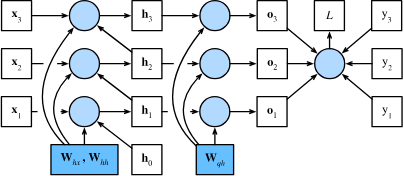
:label:`fig_rnn_bptt`

As just mentioned, the model parameters in :numref:`fig_rnn_bptt` 
are $\mathbf{W}_\textrm{hx}$, $\mathbf{W}_\textrm{hh}$, and $\mathbf{W}_\textrm{qh}$. 
Generally, training this model requires 
gradient computation with respect to these parameters
$\partial L/\partial \mathbf{W}_\textrm{hx}$, $\partial L/\partial \mathbf{W}_\textrm{hh}$, and $\partial L/\partial \mathbf{W}_\textrm{qh}$.
According to the dependencies in :numref:`fig_rnn_bptt`,
we can traverse in the opposite direction of the arrows
to calculate and store the gradients in turn.
To flexibly express the multiplication of 
matrices, vectors, and scalars of different shapes
in the chain rule,
we continue to use the $\textrm{prod}$ operator 
as described in :numref:`sec_backprop`.


First of all, differentiating the objective function
with respect to the model output at any time step $t$
is fairly straightforward:

$$\frac{\partial L}{\partial \mathbf{o}_t} =  \frac{\partial l (\mathbf{o}_t, y_t)}{T \cdot \partial \mathbf{o}_t} \in \mathbb{R}^q.$$
:eqlabel:`eq_bptt_partial_L_ot`

Now we can calculate the gradient of the objective 
with respect to the parameter $\mathbf{W}_\textrm{qh}$
in the output layer:
$\partial L/\partial \mathbf{W}_\textrm{qh} \in \mathbb{R}^{q \times h}$. 
Based on :numref:`fig_rnn_bptt`, 
the objective $L$ depends on $\mathbf{W}_\textrm{qh}$ 
via $\mathbf{o}_1, \ldots, \mathbf{o}_T$. 
Using the chain rule yields

$$
\frac{\partial L}{\partial \mathbf{W}_\textrm{qh}}
= \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{o}_t}, \frac{\partial \mathbf{o}_t}{\partial \mathbf{W}_\textrm{qh}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{o}_t} \mathbf{h}_t^\top,
$$

where $\partial L/\partial \mathbf{o}_t$
is given by :eqref:`eq_bptt_partial_L_ot`.

Next, as shown in :numref:`fig_rnn_bptt`,
at the final time step $T$,
the objective function
$L$ depends on the hidden state $\mathbf{h}_T$ 
only via $\mathbf{o}_T$.
Therefore, we can easily find the gradient 
$\partial L/\partial \mathbf{h}_T \in \mathbb{R}^h$
using the chain rule:

$$\frac{\partial L}{\partial \mathbf{h}_T} = \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{o}_T}, \frac{\partial \mathbf{o}_T}{\partial \mathbf{h}_T} \right) = \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_T}.$$
:eqlabel:`eq_bptt_partial_L_hT_final_step`

It gets trickier for any time step $t < T$,
where the objective function $L$ depends on 
$\mathbf{h}_t$ via $\mathbf{h}_{t+1}$ and $\mathbf{o}_t$.
According to the chain rule,
the gradient of the hidden state
$\partial L/\partial \mathbf{h}_t \in \mathbb{R}^h$
at any time step $t < T$ can be recurrently computed as:


$$\frac{\partial L}{\partial \mathbf{h}_t} = \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_{t+1}}, \frac{\partial \mathbf{h}_{t+1}}{\partial \mathbf{h}_t} \right) + \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{o}_t}, \frac{\partial \mathbf{o}_t}{\partial \mathbf{h}_t} \right) = \mathbf{W}_\textrm{hh}^\top \frac{\partial L}{\partial \mathbf{h}_{t+1}} + \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_t}.$$
:eqlabel:`eq_bptt_partial_L_ht_recur`

For analysis, expanding the recurrent computation
for any time step $1 \leq t \leq T$ gives

$$\frac{\partial L}{\partial \mathbf{h}_t}= \sum_{i=t}^T {\left(\mathbf{W}_\textrm{hh}^\top\right)}^{T-i} \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_{T+t-i}}.$$
:eqlabel:`eq_bptt_partial_L_ht`

We can see from :eqref:`eq_bptt_partial_L_ht` 
that this simple linear example already
exhibits some key problems of long sequence models:
it involves potentially very large powers of $\mathbf{W}_\textrm{hh}^\top$.
In it, eigenvalues smaller than 1 vanish
and eigenvalues larger than 1 diverge.
This is numerically unstable,
which manifests itself in the form of vanishing 
and exploding gradients.
One way to address this is to truncate the time steps
at a computationally convenient size 
as discussed in :numref:`subsec_bptt_analysis`. 
In practice, this truncation can also be effected 
by detaching the gradient after a given number of time steps.
Later on, we will see how more sophisticated sequence models 
such as long short-term memory can alleviate this further. 

Finally, :numref:`fig_rnn_bptt` shows 
that the objective function $L$ 
depends on model parameters $\mathbf{W}_\textrm{hx}$ and $\mathbf{W}_\textrm{hh}$
in the hidden layer via hidden states
$\mathbf{h}_1, \ldots, \mathbf{h}_T$.
To compute gradients with respect to such parameters
$\partial L / \partial \mathbf{W}_\textrm{hx} \in \mathbb{R}^{h \times d}$ and $\partial L / \partial \mathbf{W}_\textrm{hh} \in \mathbb{R}^{h \times h}$,
we apply the chain rule giving

$$
\begin{aligned}
\frac{\partial L}{\partial \mathbf{W}_\textrm{hx}}
&= \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_\textrm{hx}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{x}_t^\top,\\
\frac{\partial L}{\partial \mathbf{W}_\textrm{hh}}
&= \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_\textrm{hh}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{h}_{t-1}^\top,
\end{aligned}
$$

where $\partial L/\partial \mathbf{h}_t$
which is recurrently computed by
:eqref:`eq_bptt_partial_L_hT_final_step`
and :eqref:`eq_bptt_partial_L_ht_recur`
is the key quantity that affects the numerical stability.



Since backpropagation through time is the application of backpropagation in RNNs,
as we have explained in :numref:`sec_backprop`,
training RNNs alternates forward propagation with
backpropagation through time.
Moreover, backpropagation through time
computes and stores the above gradients in turn.
Specifically, stored intermediate values
are reused to avoid duplicate calculations,
such as storing $\partial L/\partial \mathbf{h}_t$
to be used in computation of both $\partial L / \partial \mathbf{W}_\textrm{hx}$ 
and $\partial L / \partial \mathbf{W}_\textrm{hh}$.


### Summary

Backpropagation through time is merely an application of backpropagation to sequence models with a hidden state.
Truncation, such as regular or randomized, is needed for computational convenience and numerical stability.
High powers of matrices can lead to divergent or vanishing eigenvalues. This manifests itself in the form of exploding or vanishing gradients.
For efficient computation, intermediate values are cached during backpropagation through time.



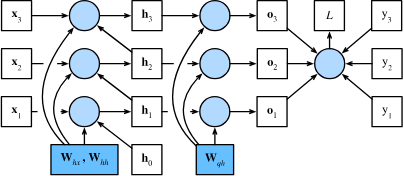

## My Note for 9.7.2
Section 9.7.2, titled "Backpropagation Through Time in Detail," moves from the general principles of computing gradients in Recurrent Neural Networks (RNNs) to a more specific, mathematical analysis of how these gradients are calculated with respect to the decomposed model parameters. This detailed breakdown is crucial for understanding the **vanishing and exploding gradient problems** in RNNs and the rationale behind practical solutions like gradient clipping and truncation.

To simplify the analysis, the sources consider an RNN model with the following characteristics:
*   **No bias parameters**.
*   The **activation function in the hidden layer is an identity mapping** ($\phi(x) = x$).
*   It focuses on a **single example input** at each time step.

Let's break down the content and formulas:

### Simplified RNN Model and Objective Function

1.  **Hidden State and Output Computation (9.7.9)**:
    At each time step $t$, the hidden state $\mathbf{h}_t \in \mathbb{R}^h$ and the output $\mathbf{o}_t \in \mathbb{R}^q$ are computed as follows:
    $\mathbf{h}_t = \mathbf{W}_\textrm{hx} \mathbf{x}_t + \mathbf{W}_\textrm{hh} \mathbf{h}_{t-1}$
    $\mathbf{o}_t = \mathbf{W}_\textrm{qh} \mathbf{h}_{t}$

    *   **$\mathbf{x}_t \in \mathbb{R}^d$**: The input at time step $t$.
    *   **$\mathbf{y}_t$**: The desired target (label) at time step $t$.
    *   **$\mathbf{h}_t \in \mathbb{R}^h$**: The hidden state at time step $t$, where $h$ is the number of hidden units. This state captures and retains the sequence's historical information up to the current time step.
    *   **$\mathbf{o}_t \in \mathbb{R}^q$**: The output at time step $t$, where $q$ is the output dimension.
    *   **$\mathbf{W}_\textrm{hx} \in \mathbb{R}^{h \times d}$**: The weight parameter connecting the current input $\mathbf{x}_t$ to the hidden state $\mathbf{h}_t$.
    *   **$\mathbf{W}_\textrm{hh} \in \mathbb{R}^{h \times h}$**: The weight parameter describing how the hidden state from the previous time step $\mathbf{h}_{t-1}$ influences the current hidden state $\mathbf{h}_t$. This is the **recurrent connection**.
    *   **$\mathbf{W}_\textrm{qh} \in \mathbb{R}^{q \times h}$**: The weight parameter connecting the hidden state $\mathbf{h}_t$ to the output $\mathbf{o}_t$.

    **Derivation/Explanation**: This formula defines the forward pass of a simplified RNN. The current hidden state $\mathbf{h}_t$ is a linear combination of the current input $\mathbf{x}_t$ (transformed by $\mathbf{W}_\textrm{hx}$) and the previous hidden state $\mathbf{h}_{t-1}$ (transformed by $\mathbf{W}_\textrm{hh}$). The output $\mathbf{o}_t$ is then a linear transformation of the current hidden state $\mathbf{h}_t$. This simplified model with identity activation makes the derivatives simpler for analytical purposes, but the core principles of dependency apply to more complex activation functions like tanh.

2.  **Objective Function (Loss) (9.7.10)**:
    The objective function $L$, representing the loss over $T$ time steps from the beginning of the sequence, is defined as:
    $L = \frac{1}{T} \sum_{t=1}^T l(\mathbf{o}_t, \mathbf{y}_t)$

    *   **$l(\mathbf{o}_t, \mathbf{y}_t)$**: The loss at a specific time step $t$, comparing the model's output $\mathbf{o}_t$ with the desired target $\mathbf{y}_t$.

    **Derivation/Explanation**: This is the standard way to define the total loss for sequence models: summing (or averaging, as here) the losses computed at each individual time step. This means that errors at later time steps can influence the gradients throughout the entire sequence back to the beginning.

### Visualizing Dependencies: Fig. 9.7.2
**Fig. 9.7.2** illustrates the computational graph for an RNN model with three time steps.
*   It visually shows how each hidden state $\mathbf{h}_t$ depends on the input $\mathbf{x}_t$, the previous hidden state $\mathbf{h}_{t-1}$, and the weight parameters $\mathbf{W}_\textrm{hx}$ and $\mathbf{W}_\textrm{hh}$.
*   It also shows how each output $\mathbf{o}_t$ depends on $\mathbf{h}_t$ and $\mathbf{W}_\textrm{qh}$.
*   This graph is essential for understanding **Backpropagation Through Time (BPTT)**, as it shows the dependencies that need to be traversed in reverse to compute gradients.

### Gradient Computation in Detail

Training this RNN model requires computing gradients with respect to all its parameters: $\partial L/\partial \mathbf{W}_\textrm{hx}$, $\partial L/\partial \mathbf{W}_\textrm{hh}$, and $\partial L/\partial \mathbf{W}_\textrm{qh}$. This involves traversing the computational graph in the opposite direction of the arrows, applying the **chain rule** and reusing intermediate values to avoid duplicate calculations. The $\textrm{prod}$ operator is used to flexibly express multiplication of matrices, vectors, and scalars of different shapes.

1.  **Gradient of $L$ with respect to Output $\mathbf{o}_t$ (9.7.11)**:
    $\frac{\partial L}{\partial \mathbf{o}_t} = \frac{\partial l (\mathbf{o}_t, \mathbf{y}_t)}{T \cdot \partial \mathbf{o}_t} \in \mathbb{R}^q$

    **Derivation/Explanation**: This is the gradient of the overall objective function $L$ with respect to the output at a specific time step $\mathbf{o}_t$. Since $L$ is the average of individual losses $l(\mathbf{o}_t, \mathbf{y}_t)$ over $T$ time steps, the derivative of $L$ with respect to $\mathbf{o}_t$ is simply the derivative of $l(\mathbf{o}_t, \mathbf{y}_t)$ with respect to $\mathbf{o}_t$, scaled by $1/T$.

2.  **Gradient of $L$ with respect to Output Layer Weights $\mathbf{W}_\textrm{qh}$ (9.7.12)**:
    $\frac{\partial L}{\partial \mathbf{W}_\textrm{qh}} = \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{o}_t}, \frac{\partial \mathbf{o}_t}{\partial \mathbf{W}_\textrm{qh}}\right) = \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{o}_t} \mathbf{h}_t^\top$

    **Derivation/Explanation**: The objective $L$ depends on $\mathbf{W}_\textrm{qh}$ through all outputs $\mathbf{o}_1, \ldots, \mathbf{o}_T$. Therefore, we sum the contributions from each time step. For a single time step $t$, from the output equation $\mathbf{o}_t = \mathbf{W}_\textrm{qh} \mathbf{h}_t$, the derivative of $\mathbf{o}_t$ with respect to $\mathbf{W}_\textrm{qh}$ is $\mathbf{h}_t^\top$. Applying the chain rule, $\frac{\partial L}{\partial \mathbf{W}_\textrm{qh}}$ is the sum of $(\frac{\partial L}{\partial \mathbf{o}_t}) \mathbf{h}_t^\top$ for all $t$.

3.  **Gradient of $L$ with respect to Hidden State at Final Time Step $\mathbf{h}_T$ (9.7.13)**:
    $\frac{\partial L}{\partial \mathbf{h}_T} = \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{o}_T}, \frac{\partial \mathbf{o}_T}{\partial \mathbf{h}_T} \right) = \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_T}$

    **Derivation/Explanation**: At the final time step $T$, the objective function $L$ depends on the hidden state $\mathbf{h}_T$ *only* via the output $\mathbf{o}_T$. From $\mathbf{o}_T = \mathbf{W}_\textrm{qh} \mathbf{h}_T$, the derivative of $\mathbf{o}_T$ with respect to $\mathbf{h}_T$ is $\mathbf{W}_\textrm{qh}$. Using the chain rule, $\frac{\partial L}{\partial \mathbf{h}_T}$ is $\mathbf{W}_\textrm{qh}^\top$ multiplied by $\frac{\partial L}{\partial \mathbf{o}_T}$.

4.  **Gradient of $L$ with respect to Hidden State at Time Step $t < T$ (9.7.14)**:
    $\frac{\partial L}{\partial \mathbf{h}_t} = \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_{t+1}}, \frac{\partial \mathbf{h}_{t+1}}{\partial \mathbf{h}_t} \right) + \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{o}_t}, \frac{\partial \mathbf{o}_t}{\partial \mathbf{h}_t} \right) = \mathbf{W}_\textrm{hh}^\top \frac{\partial L}{\partial \mathbf{h}_{t+1}} + \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_t}$

    **Derivation/Explanation**: This is the **recurrent part of backpropagation**. For any time step $t < T$, the objective function $L$ depends on $\mathbf{h}_t$ through two paths:
    *   **Direct path to current output**: Through $\mathbf{o}_t$, which contributes to $l(\mathbf{o}_t, \mathbf{y}_t)$ and thus to $L$. From $\mathbf{o}_t = \mathbf{W}_\textrm{qh} \mathbf{h}_t$, the derivative $\frac{\partial \mathbf{o}_t}{\partial \mathbf{h}_t} = \mathbf{W}_\textrm{qh}$. So, this path contributes $\mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_t}$.
    *   **Recurrent path to future hidden states**: Through $\mathbf{h}_{t+1}$ (and all subsequent hidden states and outputs). From $\mathbf{h}_{t+1} = \mathbf{W}_\textrm{hx} \mathbf{x}_{t+1} + \mathbf{W}_\textrm{hh} \mathbf{h}_t$, the derivative $\frac{\partial \mathbf{h}_{t+1}}{\partial \mathbf{h}_t} = \mathbf{W}_\textrm{hh}$. So, this path contributes $\mathbf{W}_\textrm{hh}^\top \frac{\partial L}{\partial \mathbf{h}_{t+1}}$.
    The chain rule sums these two contributions to get the total gradient $\frac{\partial L}{\partial \mathbf{h}_t}$.

5.  **Expanded Gradient for Hidden State $\mathbf{h}_t$ (9.7.15)**:
    $\frac{\partial L}{\partial \mathbf{h}_t}= \sum_{i=t}^T {\left(\mathbf{W}_\textrm{hh}^\top\right)}^{T-i} \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_{T+t-i}}$

    **Derivation/Explanation**: This formula is obtained by **recursively expanding equation (9.7.14)**. It shows that the gradient with respect to $\mathbf{h}_t$ depends on a sum of terms, where each term involves powers of $\mathbf{W}_\textrm{hh}^\top$.
    *   The term $(\mathbf{W}_\textrm{hh}^\top)^{T-i}$ signifies that the influence of $\mathbf{h}_t$ on a future hidden state $\mathbf{h}_i$ (and thus on its loss contribution) involves $T-i$ multiplications by $\mathbf{W}_\textrm{hh}^\top$ as the gradient backpropagates through time.
    *   **Significance for Vanishing/Exploding Gradients**: This explicit form reveals the **fundamental cause of numerical instability** in RNNs.
        *   If the eigenvalues of $\mathbf{W}_\textrm{hh}^\top$ (or $\mathbf{W}_\textrm{hh}$) are consistently **smaller than 1**, repeated multiplication by these matrices causes the gradient terms to **vanish** (approach zero). This makes it difficult for the model to learn long-term dependencies.
        *   If the eigenvalues are consistently **larger than 1**, repeated multiplication causes the gradient terms to **explode** (become excessively large). This can lead to unstable training, huge parameter updates, and divergence.
    This problem is often addressed by **truncating time steps** (limiting how far back gradients are propagated) or using more sophisticated architectures like LSTMs.

6.  **Gradients with respect to Hidden Layer Weights $\mathbf{W}_\textrm{hx}$ and $\mathbf{W}_\textrm{hh}$ (9.7.16)**:
    $\frac{\partial L}{\partial \mathbf{W}_\textrm{hx}} = \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_\textrm{hx}}\right) = \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{x}_t^\top$
    $\frac{\partial L}{\partial \mathbf{W}_\textrm{hh}} = \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_\textrm{hh}}\right) = \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{h}_{t-1}^\top$

    **Derivation/Explanation**: The objective function $L$ depends on $\mathbf{W}_\textrm{hx}$ and $\mathbf{W}_\textrm{hh}$ via all hidden states $\mathbf{h}_1, \ldots, \mathbf{h}_T$. Similar to $\mathbf{W}_\textrm{qh}$, we sum the contributions from each time step:
    *   For $\mathbf{W}_\textrm{hx}$: From $\mathbf{h}_t = \mathbf{W}_\textrm{hx} \mathbf{x}_t + \mathbf{W}_\textrm{hh} \mathbf{h}_{t-1}$, the derivative of $\mathbf{h}_t$ with respect to $\mathbf{W}_\textrm{hx}$ is $\mathbf{x}_t^\top$.
    *   For $\mathbf{W}_\textrm{hh}$: From $\mathbf{h}_t = \mathbf{W}_\textrm{hx} \mathbf{x}_t + \mathbf{W}_\textrm{hh} \mathbf{h}_{t-1}$, the derivative of $\mathbf{h}_t$ with respect to $\mathbf{W}_\textrm{hh}$ is $\mathbf{h}_{t-1}^\top$.
    These gradients depend critically on $\frac{\partial L}{\partial \mathbf{h}_t}$, which is computed recurrently by (9.7.13) and (9.7.14) and is the **key quantity affecting numerical stability**. During BPTT, these intermediate $\frac{\partial L}{\partial \mathbf{h}_t}$ values are cached and reused for efficient computation.

### Summary of Backpropagation Through Time

In essence, Backpropagation Through Time (BPTT) is the direct application of the backpropagation algorithm to unrolled RNN computational graphs. It involves:
*   **Unrolling the RNN**: Expanding the network across time steps, treating it like a deep feedforward network where parameters are shared across layers (time steps).
*   **Applying the Chain Rule**: Gradients are computed by traversing the unrolled graph backward from the output to the input.
*   **Summing Gradients**: The gradient for each parameter (e.g., $\mathbf{W}_\textrm{hh}$) must be summed across all time steps where it appears.
*   **Numerical Instability**: The long chains of matrix products, especially involving powers of $\mathbf{W}_\textrm{hh}^\top$, lead to **vanishing or exploding gradients**, making training difficult for long sequences.
*   **Practical Solutions**: **Truncation** (regular or randomized) is used for computational convenience and to mitigate numerical instability by limiting the length of backpropagation paths. **Gradient clipping** is another ubiquitous heuristic that directly addresses exploding gradients by limiting their magnitude.